# Analyzing the Impact of Studying Abroad on Mental Health Using SQLlite (Alchemy) and Pandas

This project investigates the mental health effects of studying in a foreign country by analyzing student health data using PostgreSQL, Pandas, and SQLAlchemy. The dataset, sourced via Kaggle API, originates from a 2018 survey conducted at a Japanese international university and approved by ethical and regulatory boards.

The goal is to explore whether international students experience a higher risk of mental health challenges compared to the general population. Specifically, the analysis will focus on social connectedness, acculturative stress, and length of stay as potential factors contributing to depression. Through Exploratory Data Analysis (EDA) using SQL queries and Pandas-based data manipulation, the project aims to validate or challenge the studyâ€™s conclusions and provide further insights into the well-being of international student

## Load Libraries

In [1]:
%matplotlib inline
import sys
import os
scripts_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(scripts_path) # Add 'scripts' directory to sys.path
import sql_pipeline 
import data_processing_framework as kr
from  sql_pipeline  import *

import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import logging


## load data from kaggle

In [2]:
## Load Dataset using kaggle api fx
importlib.reload(kr)

students =kr.fetch_kaggle_dataset(search_query="students_mental_health_scores")
students.head() # Display the first few rows of the dataset



ðŸ”¹ Available Datasets:

Dataset 1: williammontero/students-mental-health-scores - students_mental_health_scores
Files:
  - students.csv (Size: 43485 bytes)



Enter the number of the dataset you want to use:  1



âœ… Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 50 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   inter_dom        268 non-null    object 
 1   region           268 non-null    object 
 2   gender           268 non-null    object 
 3   academic         268 non-null    object 
 4   age              268 non-null    float64
 5   age_cate         268 non-null    float64
 6   stay             268 non-null    float64
 7   stay_cate        268 non-null    object 
 8   japanese         268 non-null    float64
 9   japanese_cate    268 non-null    object 
 10  english          268 non-null    float64
 11  english_cate     268 non-null    object 
 12  intimate         260 non-null    object 
 13  religion         268 non-null    object 
 14  suicide          268 non-null    object 
 15  dep              270 non-null    object 
 16  deptype          271 non-nul

inter_dom region  gender academic   age  age_cate  stay stay_cate  japanese  \
0     Inter    SEA    Male     Grad  24.0       4.0   5.0      Long       3.0   
1     Inter    SEA    Male     Grad  28.0       5.0   1.0     Short       4.0   
2     Inter    SEA    Male     Grad  25.0       4.0   6.0      Long       4.0   
3     Inter     EA  Female     Grad  29.0       5.0   1.0     Short       2.0   
4     Inter     EA  Female     Grad  28.0       5.0   1.0     Short       1.0   

  japanese_cate  ...  friends_bi parents_bi relative_bi professional_bi  \
0       Average  ...         Yes        Yes          No              No   
1          High  ...         Yes        Yes          No              No   
2          High  ...          No         No          No              No   
3           Low  ...         Yes        Yes         Yes             Yes   
4           Low  ...         Yes        Yes          No             Yes   

  phone_bi doctor_bi religion_bi  alone_bi others_bi  internet_bi  
0       No        No          No        No        No           No  
1       No        No          No        No        No           No  
2       No        No          No        No        No           No  
3       No        No          No        No        No           No  
4       No       Yes         Yes        No        No           No  

[5 rows x 50 columns]

**List of helpful columns considering project objective.**

| Field Name    | Description                                      |
| ------------- | ------------------------------------------------ |
| `inter_dom`     | Types of students (international or domestic)   |
| `japanese_cate` | Japanese language proficiency                    |
| `english_cate`  | English language proficiency                     |
| `academic`      | Current academic level (undergraduate or graduate) |
| `age`           | Current age of student                           |
| `stay`          | Current length of stay in years                  |
| `todep`         | Total score of depression (PHQ-9 test)           |
| `tosc`          | Total score of social connectedness (SCS test)   |
| `toas`          | Total score of acculturative stress (ASISS test) |

## Data Cleaning

In [3]:
# Display the unique values for each specified column
print("Unique values in 'inter_dom':", students['inter_dom'].unique())
print("Unique values in 'japanese_cate':", students['japanese_cate'].unique())
print("Unique values in 'english_cate':", students['english_cate'].unique())
print("Unique values in 'academic':", students['academic'].unique())

# Define  mappings using lambda functions
students['inter_dom'] = students['inter_dom'].map(lambda x: 'International' if x == 'Inter' else ('Domestic' if x == 'Dom' else 'Unknown'))
students['japanese_cate'] = students['japanese_cate'].map(lambda x: 'Intermediate' if x == 'Average' else ('Advanced' if x == 'High' else ('Beginner' if x == 'Low' else 'Unknown')))
students['english_cate'] = students['english_cate'].map(lambda x: 'Advanced' if x == 'High' else ('Intermediate' if x == 'Average' else ('Beginner' if x == 'Low' else 'Unknown')))
students['academic'] = students['academic'].map(lambda x: 'Graduate' if x == 'Grad' else ('Undergraduate' if x == 'Under' else 'Unknown'))

desired_numeric_columns = ['age', 'stay', 'todep', 'tosc', 'toas']# checking for NaN values in numeric columns
students[desired_numeric_columns] = students[desired_numeric_columns].fillna(0) # Fill NaN values with 0
students['age'] = students['age'].astype(int) # Convert the 'age' column to integer type

# Display the columns after filling NaN values
print("After filling NaN values:")
print(students[desired_numeric_columns].head())

Unique values in 'inter_dom': ['Inter' 'Dom' nan]
Unique values in 'japanese_cate': ['Average' 'High' 'Low' nan]
Unique values in 'english_cate': ['High' 'Average' 'Low' nan]
Unique values in 'academic': ['Grad' 'Under' nan]
After filling NaN values:
   age  stay  todep  tosc  toas
0   24   5.0    0.0  34.0  91.0
1   28   1.0    2.0  48.0  39.0
2   25   6.0    2.0  41.0  51.0
3   29   1.0    3.0  37.0  75.0
4   28   1.0    3.0  37.0  82.0


## Create SQL db and insert record from the panda df

In [4]:
#  Insert Data from the Pandas DataFrame (students):Convert DataFrame to SQL database 
#importlib.reload(mentalhealth)
setup_and_insert_data(students, 'students_mental_health.db') # Set up the database and insert data


âœ… Database 'students_mental_health.db' created successfully.
Debug: Starting to insert data.
Debug: About to commit the transaction.
âœ… Data insertion completed successfully.
Debug: Session closed.


## EDA SQL Queries to understand Data Distribution

**Exploring and understanding the data:**
- Count the number of records (total_records )in the dataset to confirm the expected number of records
- See how many entries for each student type

### **Total number of students**

In [5]:
query1 = "SELECT COUNT(*) AS student_count FROM students_mental_health_data"
student_count_result = execute_query(query1)
student_count = student_count_result[0][0]
print(f"Total number of students: {student_count}")

Total number of students: 286


### **Total number of students per student type**

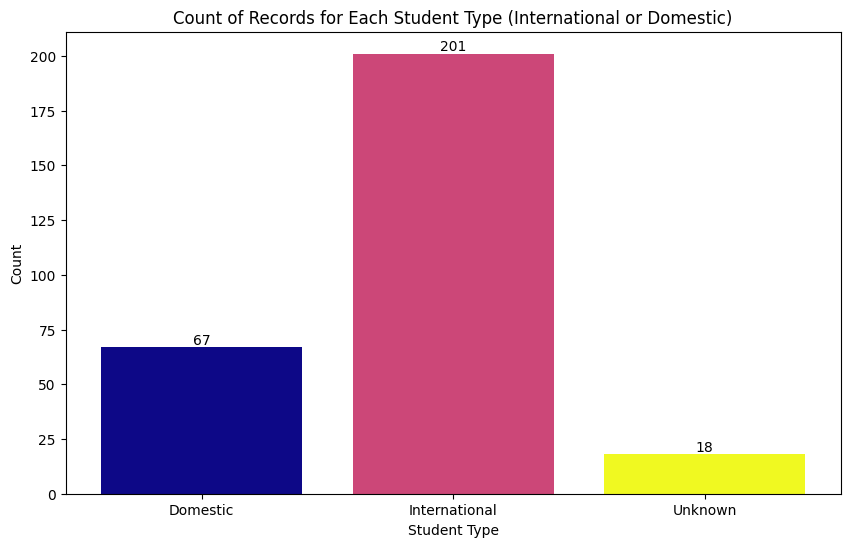

In [6]:
query2 = "SELECT student_type, COUNT(*) AS count_student_type FROM students_mental_health_data GROUP BY student_type"
result = execute_query(query2)

# Extract data for visualization, handle None values
student_types = [row[0] if row[0] is not None else 'Unknown' for row in result]
counts = [row[1] for row in result]

# Create a colormap
colors = plt.cm.plasma(np.linspace(0, 1, len(student_types)))

# Create a bar chart with dynamic colors and data labels
plt.figure(figsize=(10, 6))
bars = plt.bar(student_types, counts, color=colors)
plt.xlabel('Student Type')
plt.ylabel('Count')
plt.title('Count of Records for Each Student Type (International or Domestic)')

# Add data labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.show()

### **Querying the summary statistics of the diagnostics scores for all studentse**

In [7]:
print("Summary Statistics of Diagnostic Scores for All Students:")

# Execute the query
summary_stats = get_summary_statistics()

# Check if summary_stats is not None
if summary_stats:
        # Return insights based on the results
    insights = [
    f"- PHQ9 Depression Score: Average is {summary_stats['avg_phq']}/{summary_stats['max_phq']} (max). "
    f"Indicates mild to moderate depression; prioritize support for students with moderate to severe symptoms.",

    f"- Social Connectedness Score: Average is {summary_stats['avg_scs']}/{summary_stats['max_scs']} (max). "
    f"Shows students are socially connected; sustain programs fostering interactions to enhance well-being.",

    f"- Acculturative Stress Score: Average is {summary_stats['avg_asiss']}/{summary_stats['max_asiss']} (max). "
    f"Reflects moderate stress; provide targeted resources to help international students adapt and reduce stress."
]

    # Print the insights
    for insight in insights:
        print(insight)
else:
    print("âš  No summary statistics available. Check the database or query.")

Summary Statistics of Diagnostic Scores for All Students:
- PHQ9 Depression Score: Average is 7.67/25.0 (max). Indicates mild to moderate depression; prioritize support for students with moderate to severe symptoms.
- Social Connectedness Score: Average is 35.12/48.0 (max). Shows students are socially connected; sustain programs fostering interactions to enhance well-being.
- Acculturative Stress Score: Average is 67.83/145.0 (max). Reflects moderate stress; provide targeted resources to help international students adapt and reduce stress.


## SQL Queries to Reach a Conclusion (Based on Project Objective)

### 1. Social Connectedness Analysis
Examine the relationship between social connectedness and depression, comparing international and domestic students, and determine if lower social connectedness correlates with higher depression rates, particularly for international students.

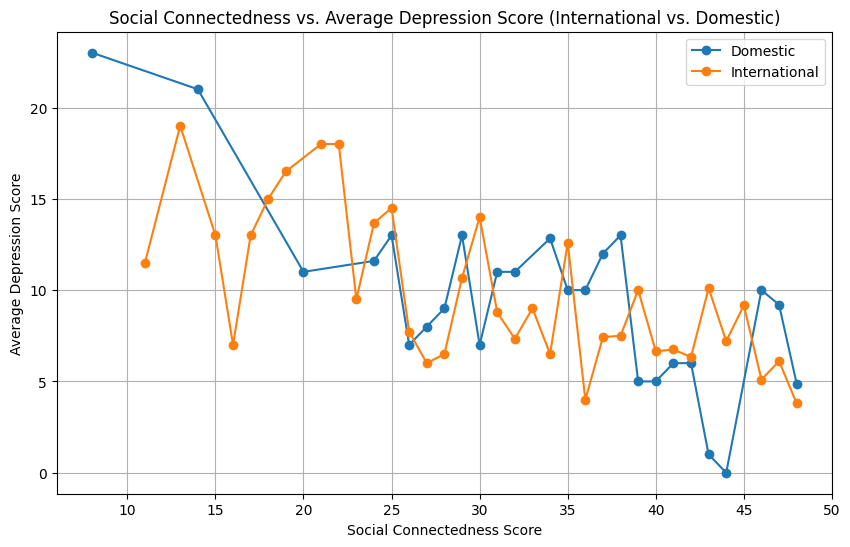

In [8]:
query3 ="""
SELECT 
    student_type, 
    social_connectedness_score, 
    COUNT(*) as number_of_students, 
    AVG(PHQ9_depression_score) as average_depression_score
FROM 
    students_mental_health_data
WHERE 
    student_type IN ('International', 'Domestic')
GROUP BY 
    student_type, social_connectedness_score
ORDER BY 
    student_type, social_connectedness_score;
"""
result3 = execute_query(query3)

df1 = pd.DataFrame(result3, columns=['student_type', 'social_connectedness_score', 'number_of_students', 'average_depression_score'])

# Plotting
plt.figure(figsize=(10, 6))
for student_type in df1['student_type'].unique():
    subset = df1[df1['student_type'] == student_type]
    plt.plot(subset['social_connectedness_score'], subset['average_depression_score'], marker='o', label=student_type)

plt.xlabel('Social Connectedness Score')
plt.ylabel('Average Depression Score')
plt.title('Social Connectedness vs. Average Depression Score (International vs. Domestic)')
plt.legend()
plt.grid(True)
plt.show()

As social connectedness increases, depression scores decrease, with a stronger negative correlation for international students than domestic students, emphasizing the importance of fostering social connections to reduce depression, especially for international students.

### 2. Acculturative Stress Analysis
Explore the impact of acculturative stress on depression, comparing international and domestic students, and determine if higher stress correlates with increased depression, particularly for international students.

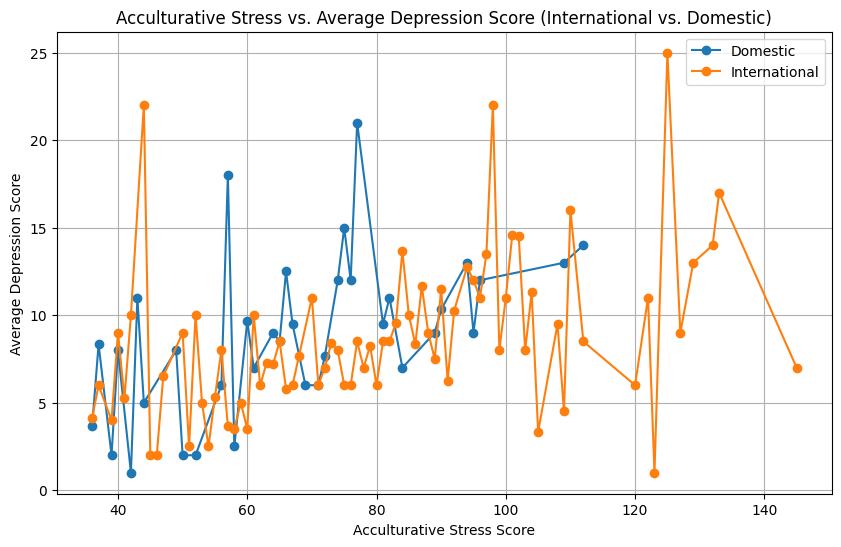

In [9]:
# Define the query for acculturative stress analysis
query4 = """
SELECT 
    student_type, 
    acculturative_stress_score, 
    COUNT(*) as number_of_students, 
    AVG(PHQ9_depression_score) as average_depression_score
FROM 
    students_mental_health_data
WHERE 
    student_type IN ('International', 'Domestic')
GROUP BY 
    student_type, acculturative_stress_score
ORDER BY 
    student_type, acculturative_stress_score;
"""

# Execute the query and get results
result4 = execute_query(query4)

# Convert results to DataFrame
df2 = pd.DataFrame(result4, columns=['student_type', 'acculturative_stress_score', 'number_of_students', 'average_depression_score'])

# Plotting
plt.figure(figsize=(10, 6))
for student_type in df2['student_type'].unique():
    subset = df2[df2['student_type'] == student_type]
    plt.plot(subset['acculturative_stress_score'], subset['average_depression_score'], marker='o', label=student_type)

plt.xlabel('Acculturative Stress Score')
plt.ylabel('Average Depression Score')
plt.title('Acculturative Stress vs. Average Depression Score (International vs. Domestic)')
plt.legend()
plt.grid(True)
plt.show()


As acculturative stress increases, depression scores rise, with a stronger correlation for international students than domestic students, highlighting the need to manage stress to reduce depression, particularly for international students.

### 3. Length of Stay Analysis
Assess whether length of stay affects depression levels, comparing international and domestic students, and observe if longer stays correlate with changes in depression, particularly for international students.

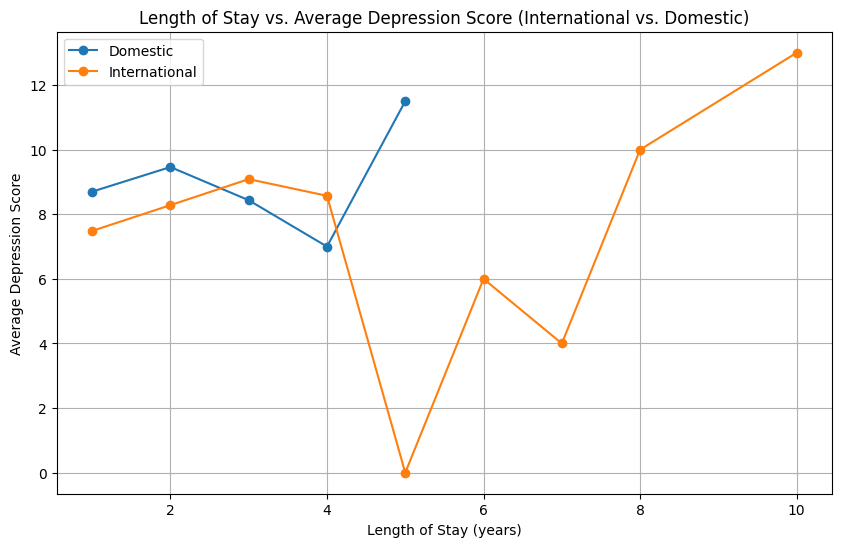

In [10]:
# Define the query for length of stay analysis
query5 = """
SELECT 
    student_type, 
    length_of_stay, 
    COUNT(*) as number_of_students, 
    AVG(PHQ9_depression_score) as average_depression_score
FROM 
    students_mental_health_data
WHERE 
    student_type IN ('International', 'Domestic')
GROUP BY 
    student_type, length_of_stay
ORDER BY 
    student_type, length_of_stay;
"""

# Execute the query and get results
result5 = execute_query(query5)

# Convert results to DataFrame
df3 = pd.DataFrame(result5, columns=['student_type', 'length_of_stay', 'number_of_students', 'average_depression_score'])

# Plotting
plt.figure(figsize=(10, 6))
for student_type in df3['student_type'].unique():
    subset = df3[df3['student_type'] == student_type]
    plt.plot(subset['length_of_stay'], subset['average_depression_score'], marker='o', label=student_type)

plt.xlabel('Length of Stay (years)')
plt.ylabel('Average Depression Score')
plt.title('Length of Stay vs. Average Depression Score (International vs. Domestic)')
plt.legend()
plt.grid(True)
plt.show()


There is no clear linear trend in depression scores based on length of stay, but international students show more variability, with higher scores after 6 years and lower scores at 4 and 5 years, while domestic students remain relatively stable, highlighting the need for targeted support for long-term international students.

### 4.  Average Depression Score

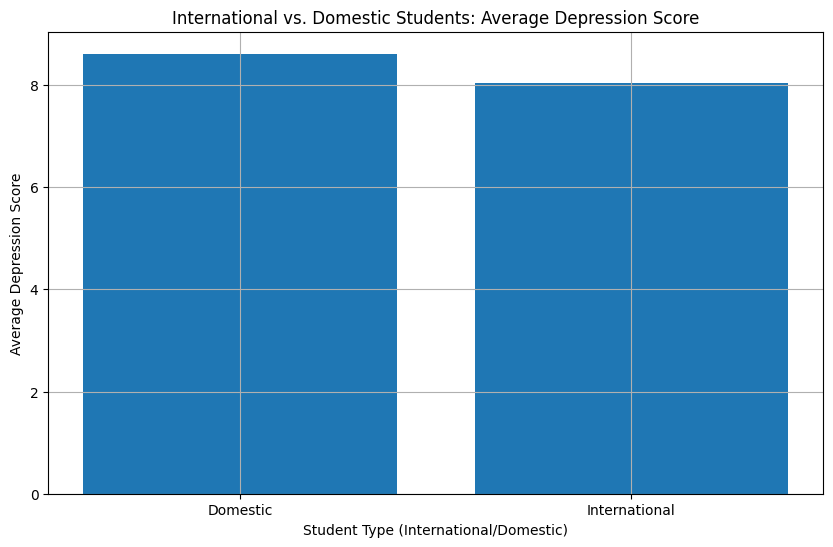

In [11]:
# Define the query for average depression score analysis
query6 = """
SELECT 
    student_type, 
    COUNT(*) as number_of_students, 
    AVG(PHQ9_depression_score) as average_depression_score
FROM 
    students_mental_health_data
WHERE 
    student_type IN ('International', 'Domestic')
GROUP BY 
    student_type;
"""

# Execute the query and get results
result6 = execute_query(query6)

# Convert results to DataFrame
df4 = pd.DataFrame(result6, columns=['student_type', 'number_of_students', 'average_depression_score'])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(df4['student_type'], df4['average_depression_score'])
plt.xlabel('Student Type (International/Domestic)')
plt.ylabel('Average Depression Score')
plt.title('International vs. Domestic Students: Average Depression Score')
plt.grid(True)
plt.show()


The bar chart shows international students have slightly higher average depression scores (8.5) than domestic students (8), emphasizing the need for targeted mental health interventions, especially for international students.

### Additional Analysis: Correlation Matrix
Analyze correlations between variables, particularly with depression scores, and compare differences between international and domestic students.

In [13]:
#Query to fetch data
query = """
SELECT  student_type,age, PHQ9_depression_score, social_connectedness_score, acculturative_stress_score, length_of_stay
FROM students_mental_health_data
"""
execute_query
# Load data into a Pandas DataFrame
df = pd.read_sql(query, sql_pipeline.engine)
print("Sample Data:")
df.head()

Sample Data:


student_type  age  PHQ9_depression_score  social_connectedness_score  \
0  International   24                      0                          34   
1  International   28                      2                          48   
2  International   25                      2                          41   
3  International   29                      3                          37   
4  International   28                      3                          37   

   acculturative_stress_score  length_of_stay  
0                          91             5.0  
1                          39             1.0  
2                          51             6.0  
3                          75             1.0  
4                          82             1.0

In [14]:
# Calculate the correlation matrix for the entire dataset
correlation_matrix = df.corr(numeric_only=True)
print("\nCorrelation Matrix for All Students:")
correlation_matrix


Correlation Matrix for All Students:


age  PHQ9_depression_score  \
age                         1.000000               0.289647   
PHQ9_depression_score       0.289647               1.000000   
social_connectedness_score  0.667751              -0.082890   
acculturative_stress_score  0.567610               0.523939   
length_of_stay              0.464107               0.188743   

                            social_connectedness_score  \
age                                           0.667751   
PHQ9_depression_score                        -0.082890   
social_connectedness_score                    1.000000   
acculturative_stress_score                    0.143851   
length_of_stay                                0.244895   

                            acculturative_stress_score  length_of_stay  
age                                           0.567610        0.464107  
PHQ9_depression_score                         0.523939        0.188743  
social_connectedness_score                    0.143851        0.244895  
acculturative_stress_score                    1.000000        0.236328  
length_of_stay                                0.236328        1.000000

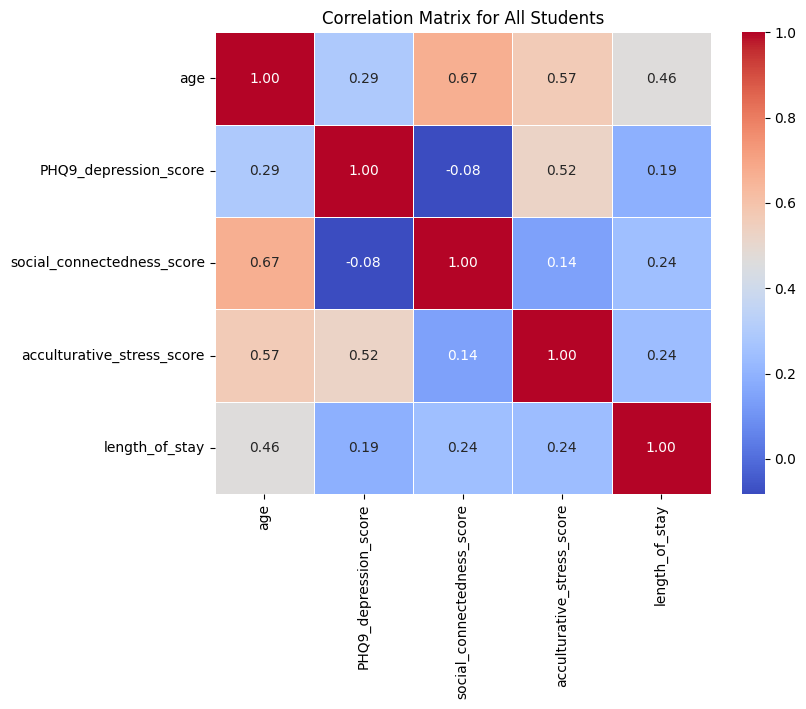

In [15]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for All Students")
plt.show()

In [16]:
# Split the dataset into international and domestic students
international_students = df[df['student_type'] == 'International']
domestic_students = df[df['student_type'] == 'Domestic']

In [17]:
# Calculate correlation matrices for international and domestic students
international_corr = international_students.corr(numeric_only=True)
domestic_corr = domestic_students.corr(numeric_only=True)

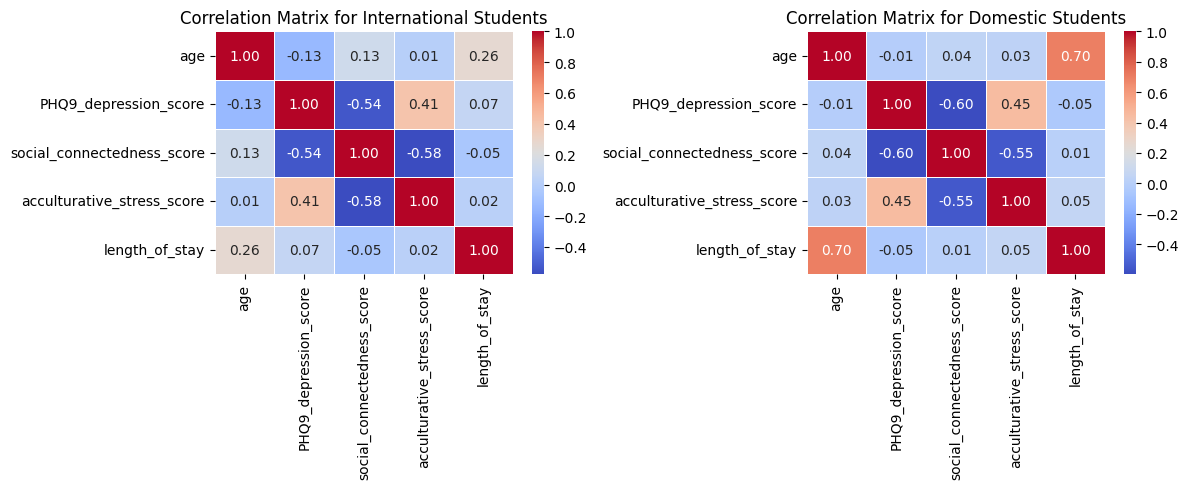

In [18]:
# Visualize correlation matrices for international and domestic students
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(international_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for International Students")

plt.subplot(1, 2, 2)
sns.heatmap(domestic_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Domestic Students")

plt.tight_layout()
plt.show()

#### **Insights**

- Age:
>- International Students: Age has a weak positive correlation with length of stay (0.26) and minimal impact on other variables.
>- Domestic Students: Age has a strong positive correlation with length of stay (0.70) but minimal impact on other variables.
- PHQ9 Depression Score:
>- Strong negative correlation with social connectedness (-0.54 for international, -0.60 for domestic).
>- Moderate positive correlation with acculturative stress (0.41 for international, 0.45 for domestic).
- Social Connectedness:
>- Strong negative correlation with acculturative stress (-0.58 for international, -0.55 for domestic).
>- Weak correlation with length of stay for both groups.
- Acculturative Stress:
>- Strong negative correlation with social connectedness for both groups.
>- Weak correlation with length of stay.
- Length of Stay:
>- Strong positive correlation with age for domestic students (0.70).
>- Weak correlation with other variables for both groups.

## Key Outcomes & Recommendations

### **Recap**

- Overall Mental Health Scores: Average PHQ9 Depression Score is 7.67/25.0, indicating mild to moderate depression among students. There's a need to target support for those with moderate to severe depression.
- Average Social Connectedness Score is 35.12/48.0, showing that students are generally well-connected socially. Maintaining programs that foster interactions is essential for student well-being.
- Average Acculturative Stress Score is 67.83/145.0, reflecting moderate stress levels. Additional resources are needed to help students, particularly international ones, adapt to the cultural environment and reduce stress.
- Older students, both international and domestic, tend to have better social connections. This suggests that age helps build a supportive network over time.

**Length of Stay:**
- Does not significantly impact mental health outcomes for either group.However, it has a weak negative correlation with depression for both groups.
- For international students, depression decreases initially and then rises after 6 years, indicating that length of stay impacts depression differently for each group.

**Social Connectedness Reduces Depression:**
- Both international and domestic students benefit from social connectedness.
- For international students, the moderate negative correlation (-0.54) indicates that better social connections help reduce depression.
- For domestic students, the weak negative correlation (-0.083) suggests a similar but less pronounced effect.

**Acculturative Stress Increases Depression:**
- International students face significant acculturative stress, which is positively correlated with depression (0.41).
- Domestic students also experience this, but the correlation is slightly higher (0.45).

**International Students:**
- Higher acculturative stress and lower social connectedness are strongly linked to higher depression scores highlighting their greater mental health challenges..
- Age has a minor impact, with older students having slightly longer stays.

**Domestic Students:**
- Similar trends as international students, but age is more strongly linked to length of stay.
- Social connectedness and acculturative stress remain key factors influencing depression.


### Recommendations

1. **Targeted Support for International Students**: Provide stress management resources, mentorship, and social programs to foster connections and build support networks.  
2. **General Mental Health Support**: Offer counseling, workshops, and peer support to all students, focusing on reducing stress and improving social connectedness.  
3. **Age-Specific Interventions**: Address age-related challenges, such as longer stays for older international students.  
4. **Monitor Long-Term Students**: Regularly check in with long-term students, especially international ones, to provide ongoing support and prevent increased depression.

### Summary of Further Studies

To build on current insights, further studies are needed to explore causal relationships and develop robust strategies. Key areas include:

1. **Longitudinal Studies**: Track mental health trends over time to assess the impact of interventions.
2. **Extracurricular Activities**: Examine how clubs, sports, and cultural events influence social connectedness and stress.
3. **Academic Pressure**: Compare its impact on international and domestic students.
4. **Cultural Background**: Study how cultural differences affect adaptation and mental health.
5. **Personalized Support**: Evaluate tailored mental health programs.
6. **Social Media**: Analyze its role in shaping social connectedness and mental health.
7. **Housing**: Assess how accommodation types impact well-being.
8. **Language Proficiency**: Investigate its effect on stress and social integration.
9. **Support Services**: Evaluate the effectiveness of counseling and orientation programs.
10. **Peer Support**: Study the impact of mentorship and peer networks.

These studies will provide deeper insights and more effective strategies to enhance student well-being.

## Drop db for Reproducibility

In [19]:
# Ensure all connections are closed
drop_database('students_mental_health.db')

âœ… Database 'students_mental_health.db' dropped successfully.


## Conclusion
Targeted support and tailored interventions are crucial for improving student mental health. Addressing international students' unique challenges fosters a more inclusive and supportive university environment for all.